The goal here is to evaluate the errors introduced adversarial training by a bit-wise comparison of the original weight values with the modified values.

In [4]:
import numpy as np
from matplotlib import pyplot as plt

In [5]:
origWeights = np.load('origWeights.npy')
modifiedWeights = np.load('modifiedWeights.npy')
origBiases = np.load('origBiases.npy')
modifiedBiases = np.load('modifiedBiases.npy')

In [6]:
def compute_minAndMax(listArrays):
    '''
    Function to find the smallest and largest elements 
    in a list of numpy arrays
    '''
    minVal = np.inf
    maxVal = -np.inf
    for arr in listArrays:
        if arr.min() < minVal:
            minVal = arr.min()
        if arr.max() > maxVal:
            maxVal = arr.max()
    return minVal, maxVal

In [7]:
def scale_weights(listArrays, scaleFunc):
    '''
    scale the values in a list of arrays based on scaleFunc
    '''
    scaledListArrays = []
    for arr in listArrays:
        scaledArray = scaleFunc(arr)
        scaledListArrays.append(scaledArray)
    return scaledListArrays

In [8]:
def convert_toBinary(decFrac, res):
    '''
    Implements the standard algorithm used to convert a decimal 
    fraction into binary.
    Accepts a decimal value between 0 and 1 and returns a list of 
    0s and 1s corresponding to its binary representation. res 
    represents the bit resolution and determines the length of
    the list.
    '''
    binRep = []
    for i in range(res):
        decFrac = decFrac * 2
        binRep.append(int(decFrac))
        if int(decFrac) == 1:
            decFrac -= 1
    return binRep

In [9]:
convert_toBinary(0.499999999, 16)

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [10]:
def convert_seqToBinary(listArrays, res):
    '''
    Converts a list of arrays into binary
    '''
    binListArrays = []
    for arr in listArrays:
        # Creates a 1-D array of lists representing the binary values
        # of the array elements. The shape of the original array is
        # not preserved.
        binArray = []
        for val in np.nditer(arr):
            binArray.append(convert_toBinary(val, res))
        binListArrays.append(binArray)
    return binListArrays

In [11]:
def convert_toFraction(origValues, modifiedValues):
    '''
    computes the min and max considering all input values, 
    and maps them into [0-1)
    '''
    # Both original as well as modified vlaues are considered while 
    # finding the minimum and maximum; this ensures that all values 
    # are between 0 and 1
    origMin, origMax = compute_minAndMax(origValues)
    modifiedMin, modifiedMax = compute_minAndMax(modifiedValues)
    minThres = min(origMin, modifiedMin)
    # Since we don't want to map any of the values to 1, maxThres 
    # is set to be slightly larger than the maximum.
    maxThres = max(origMax, modifiedMax) + 1e-5
    scaleFunc = lambda x : (x - minThres)/(maxThres - minThres)
    scaledOrigValues = scale_weights(origValues, scaleFunc)
    scaledModifiedValues = scale_weights(modifiedValues, scaleFunc)
    return scaledOrigValues, scaledModifiedValues

def compute_bitErrorRate(scaledOrigWeights, scaledModifiedWeights, res):
    '''
    Takes original and modified values in [0-1) as input, and 
    computes BER by comparing their binary representations
    '''
    binOrigWeights = convert_seqToBinary(scaledOrigWeights, res)
    binModifiedWeights = convert_seqToBinary(scaledModifiedWeights, res)
    # Once the values are converted into binary, we want to iterate 
    # through the lists to compare the bit values in the original and 
    # modified arrays.
    numLayers = len(scaledOrigWeights)
    numBitErrors = np.zeros((numLayers, res), np.uint32)
    numBitVals = np.zeros((numLayers, res), np.uint32)
    for layerNo, (binOrigWeightsLayer, binModifiedWeightsLayer
                 ) in enumerate(zip(binOrigWeights, binModifiedWeights)):
        for binOrigWeight, binModifiedWeight in zip(
            binOrigWeightsLayer, binModifiedWeightsLayer):
            for bitPos, (origBit, modifiedBit
                        ) in enumerate(zip(binOrigWeight, binModifiedWeight)):
                numBitVals[layerNo][bitPos] += 1
                if origBit != modifiedBit:
                    numBitErrors[layerNo][bitPos] += 1
    bitErrorRates = numBitErrors/numBitVals
    return bitErrorRates

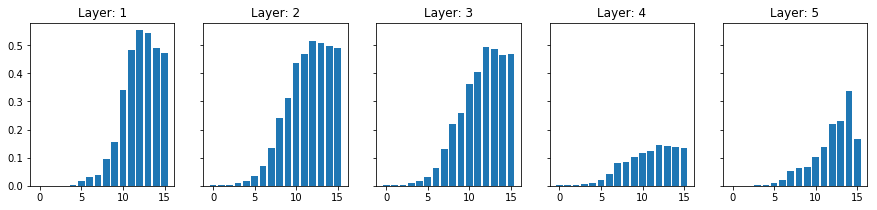

In [12]:
BIT_RESOLUTION = 16
# First, scale the weights into [0,1)
scaledOrigWeights, scaledModifiedWeights = convert_toFraction(
    origWeights, modifiedWeights)
# scaled_origWeights and scaled_modifiedWeights are in [0-1), and we want
# to convert them into binary.
ber = compute_bitErrorRate(
    scaledOrigWeights, scaledModifiedWeights, BIT_RESOLUTION)
f, axarr = plt.subplots(1,5, sharey=True, figsize=(15,3))
for layerNo in range(len(origWeights)):
    axarr[layerNo].bar(np.arange(BIT_RESOLUTION), ber[layerNo])
    axarr[layerNo].set_title('Layer: ' + str(layerNo+1))

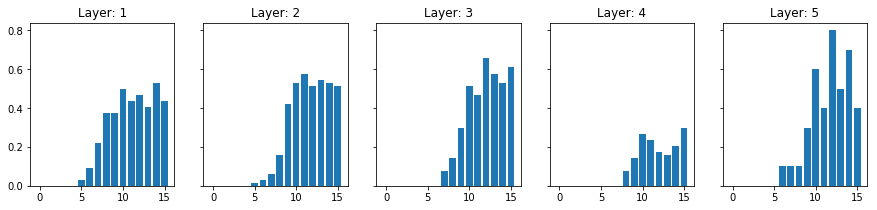

In [13]:
# First, scale the Biases into [0,1)
scaledOrigBiases, scaledModifiedBiases = convert_toFraction(
    origBiases, modifiedBiases)
# scaled_origBiases and scaled_modifiedBiases are in [0-1), and we want
# to convert them into binary.
ber = compute_bitErrorRate(
    scaledOrigBiases, scaledModifiedBiases, BIT_RESOLUTION)
f, axarr = plt.subplots(1,5, sharey=True, figsize=(15,3))
for layerNo in range(len(origBiases)):
    axarr[layerNo].bar(np.arange(BIT_RESOLUTION), ber[layerNo])
    axarr[layerNo].set_title('Layer: ' + str(layerNo+1))

In [14]:
def measure_noise(origValues, modifiedValues):
    noiseValues = []
    for origArr, modifiedArr in zip(origValues, modifiedValues):
        # error_arr is the element-wise difference of all values in the array
        errorArr = origArr - modifiedArr
        noiseValues.append(errorArr)
    return noiseValues

In [49]:
r = measure_noise(origWeights[:3], modifiedWeights[:3])
min_noise, max_noise = compute_minAndMax(r)

In [50]:
print(min_noise, max_noise)

-0.0029149242 0.0029627047


(-0.5, 3.5, 3.5, -0.5)

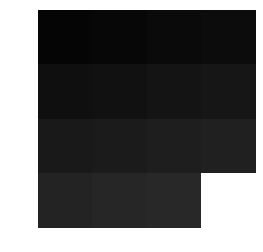

In [46]:
H = np.array([[1, 2, 3, 4],
              [5, 6, 7, 8],
              [9, 10, 11, 12],
              [13, 14, 15, 100]])  # added some commas and array creation code
plt.imshow(H, cmap='gray', vmin=-1, vmax=100)
plt.axis('off')

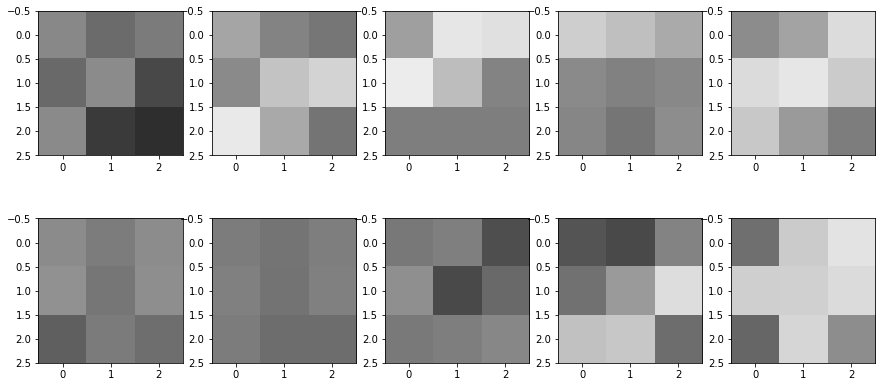

In [64]:
H = np.transpose(r[2])
f, axarr = plt.subplots(2,5, figsize=(15,7))
for num in range(10):
    axarr[num//5][num%5].imshow(H[num][0], cmap='gray', vmin=min_noise, vmax=max_noise)
plt.show()

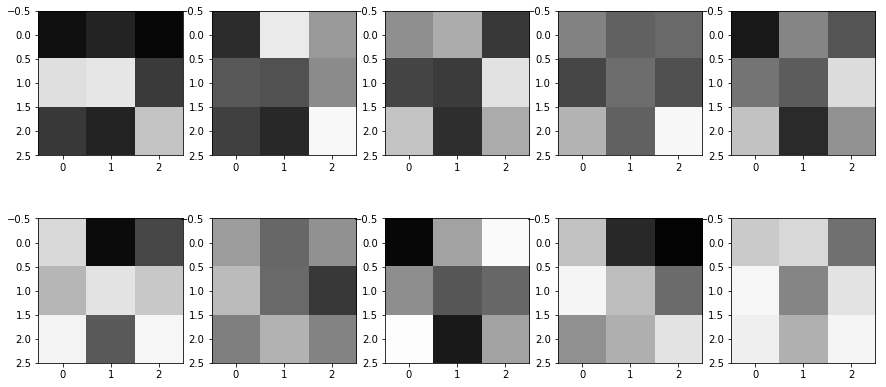

In [62]:
f, axarr = plt.subplots(2,5, figsize=(15,7))
for num in range(10):
    H = (max_noise - min_noise) * np.random.random((3,3)) + min_noise
    axarr.ravel()[num].imshow(H, cmap='gray', vmin=min_noise, vmax=max_noise)
plt.show()